In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score
from collections import Counter


Загружаем данные

In [ ]:
# Путь к загруженному файлу
file_path = "data/steam-200k.csv"

# Загрузка данных
df = pd.read_csv(file_path)

# Вывод первых строк
df.head(10)


,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
0,151603712,The Elder Scrolls V Skyrim,play,273.0,0
1,151603712,Fallout 4,purchase,1.0,0
2,151603712,Fallout 4,play,87.0,0
3,151603712,Spore,purchase,1.0,0
4,151603712,Spore,play,14.9,0
5,151603712,Fallout New Vegas,purchase,1.0,0
6,151603712,Fallout New Vegas,play,12.1,0
7,151603712,Left 4 Dead 2,purchase,1.0,0
8,151603712,Left 4 Dead 2,play,8.9,0
9,151603712,HuniePop,purchase,1.0,0


В файле нет заголовков, добавляем их

In [ ]:
# Загрузка данных без заголовков
df = pd.read_csv(file_path, header=None)

# Присвоение осмысленных названий столбцам
df.columns = ["UserID", "Game", "Action", "Hours", "Null"]

# Вывод первых строк после исправления
df.head(10)


,UserID,Game,Action,Hours,Null
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0
5,151603712,Spore,play,14.9,0
6,151603712,Fallout New Vegas,purchase,1.0,0
7,151603712,Fallout New Vegas,play,12.1,0
8,151603712,Left 4 Dead 2,purchase,1.0,0
9,151603712,Left 4 Dead 2,play,8.9,0


Последний столбец похоже весь состоит из нулей, проверим это, заодно убедившись в отсутствии пропусков

In [ ]:
# Проверка общей информации о данных
df.info()

# Проверка уникальных значений в столбце "Action"
df["Null"].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   UserID  200000 non-null  int64  
 1   Game    200000 non-null  object 
 2   Action  200000 non-null  object 
 3   Hours   200000 non-null  float64
 4   Null    200000 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 7.6+ MB


Null
0    200000
Name: count, dtype: int64

Так и оказалось, все нули (на самом деле это было видно еще в kaggle, просто добавила проверку для формальности), можем избавиться от бесполезного столбца
Пропусков в данных также не было выявленно

In [5]:
# Удаление лишнего столбца "Null"
df = df.drop(columns=["Null"])


Теперь рассмотрим первичную статистику по датасету

In [ ]:
# Количество уникальных пользователей и игр
num_users = df["UserID"].nunique()
num_games = df["Game"].nunique()

print(f"Уникальных пользователей: {num_users}, Уникальных игр: {num_games}")


Уникальных пользователей: 12393, Уникальных игр: 5155


Посмотрим статистику по времени

In [7]:
# Проверка статистики времени игры
play_times = df[df["Action"] == "play"]["Hours"]
print(play_times.describe())


count    70489.000000
mean        48.878063
std        229.335236
min          0.100000
25%          1.000000
50%          4.500000
75%         19.100000
max      11754.000000
Name: Hours, dtype: float64


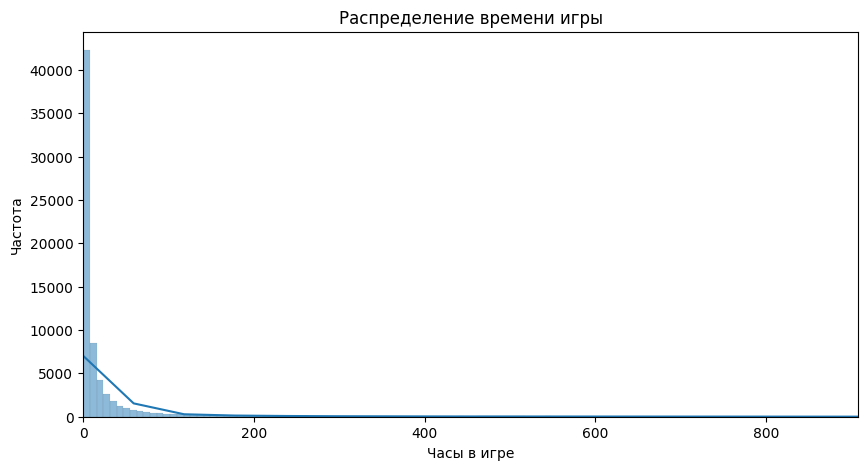

In [ ]:
# Визуализация распределения времени игры
plt.figure(figsize=(10, 5))
sns.histplot(play_times, bins=1500, kde=True)
plt.xlim(0, play_times.quantile(0.99))
plt.xlabel("Часы в игре")
plt.ylabel("Частота")
plt.title("Распределение времени игры")
plt.show()


Получили распределение, напоминающее непрерывный аналог геометрического распределения. Можно попробовать интерпритировать это, как серию успехов завлечения геймера в игру до первой неудачи (забрасывания игры)

In [ ]:
# Самые популярные игры по количеству покупок и времени в игре
top_purchased = df[df["Action"] == "purchase"]["Game"].value_counts().head(10)
top_played = df[df["Action"] == "play"].groupby("Game")["Hours"].sum().sort_values(ascending=False).head(10)

print("Топ 10 игр по покупкам:\n", top_purchased)
print("\nТоп 10 игр по времени в игре:\n", top_played)


Топ 10 игр по покупкам:
 Game
Dota 2                             4841
Team Fortress 2                    2323
Unturned                           1563
Counter-Strike Global Offensive    1412
Half-Life 2 Lost Coast              981
Counter-Strike Source               978
Left 4 Dead 2                       951
Counter-Strike                      856
Warframe                            847
Half-Life 2 Deathmatch              823
Name: count, dtype: int64

Топ 10 игр по времени в игре:
 Game
Dota 2                                         981684.6
Counter-Strike Global Offensive                322771.6
Team Fortress 2                                173673.3
Counter-Strike                                 134261.1
Sid Meier's Civilization V                      99821.3
Counter-Strike Source                           96075.5
The Elder Scrolls V Skyrim                      70889.3
Garry's Mod                                     49725.3
Call of Duty Modern Warfare 2 - Multiplayer     42009.9
Lef

Абсолютно ожидаемо, Dota 2 на первом месте по загрузкам и по времени в игре (причем с огромнейшим отрывом в 2 и 3 раза).

Еще можно заметить интересный факт, что в топе по загрузкам есть игры, которые скачивает большое число людей, но почти никто не играет: это как правило бесплатные игры или игры из наборов, которые покупали только ради одной игры.

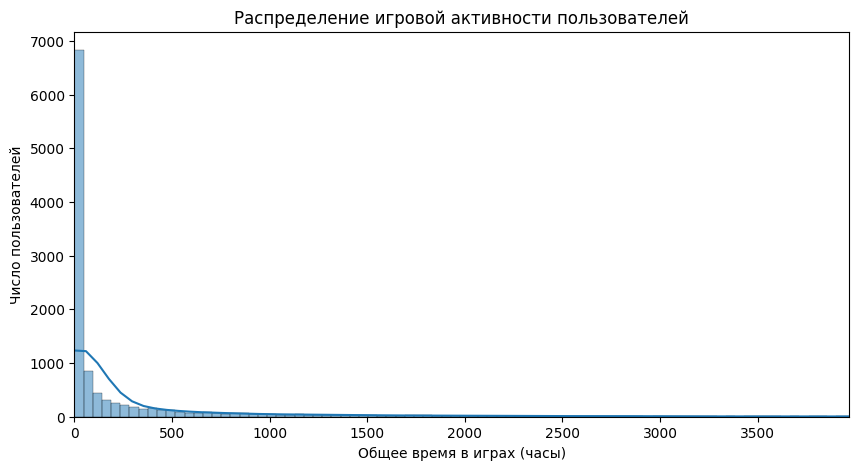

In [11]:
# Анализ активности пользователей
user_activity = df[df["Action"] == "play"].groupby("UserID")["Hours"].sum()
plt.figure(figsize=(10, 5))
sns.histplot(user_activity, bins=250, kde=True)
plt.xlim(0, user_activity.quantile(0.99))
plt.xlabel("Общее время в играх (часы)")
plt.ylabel("Число пользователей")
plt.title("Распределение игровой активности пользователей")
plt.show()


Получили похожее распределение, но с более тяжелым хвостом. Оно уже больше напоминает логнормальное

Еще немного графиков

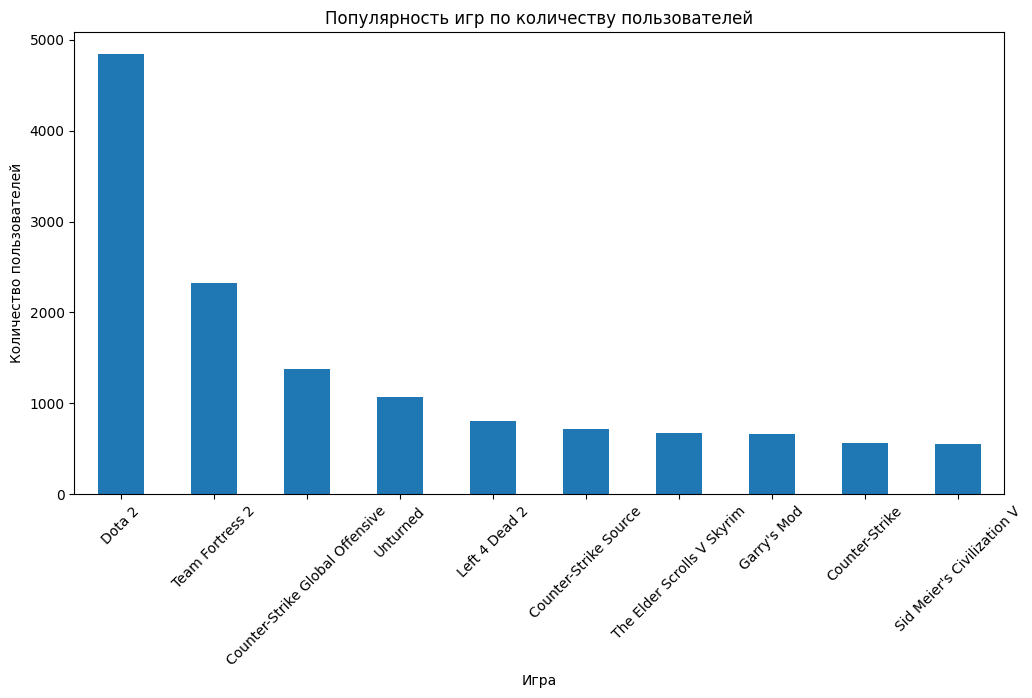

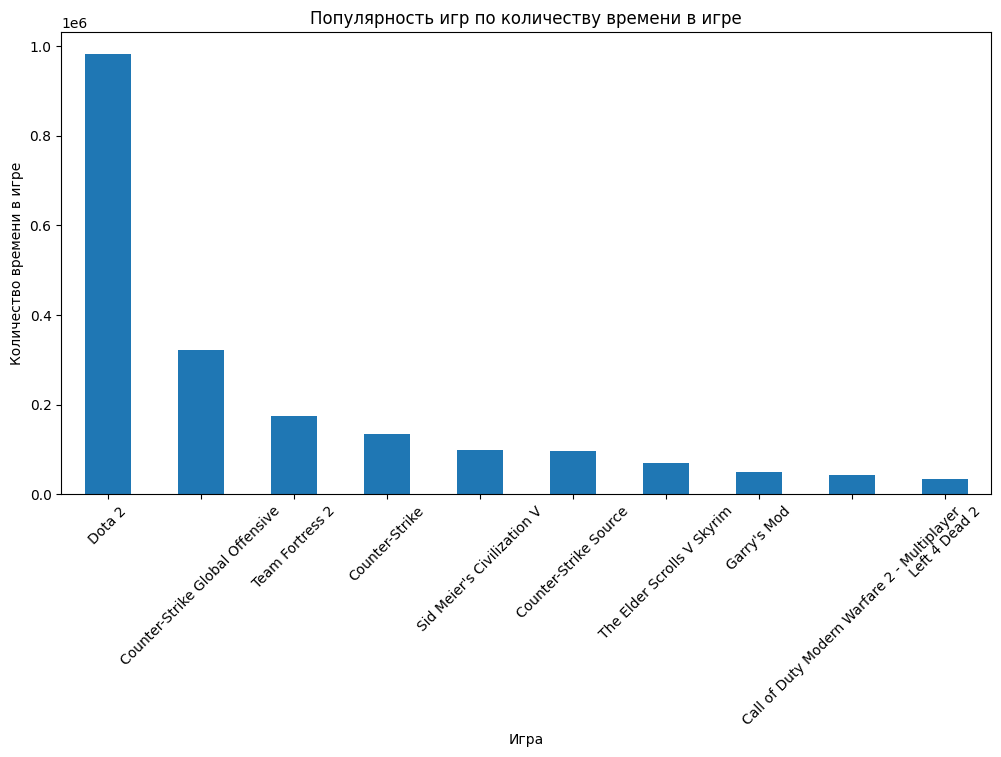

In [19]:
#Популярность игр по количеству уникальных пользователей
game_user_count = df[df["Action"] == "play"].groupby("Game")["UserID"].nunique().sort_values(ascending=False).head(10)
game_play_time = df[df["Action"] == "play"].groupby("Game")["Hours"].sum().sort_values(ascending=False).head(10)

game_user_count.plot(kind='bar', figsize=(12, 6))
plt.xlabel("Игра")
plt.ylabel("Количество пользователей")
plt.title("Популярность игр по количеству пользователей")
plt.xticks(rotation=45)
plt.show()

game_play_time.plot(kind='bar', figsize=(12, 6))
plt.xlabel("Игра")
plt.ylabel("Количество времени в игре")
plt.title("Популярность игр по количеству времени в игре")
plt.xticks(rotation=45)
plt.show()


Посчитаем корреляцию между временем в разных играх и выведем максимальную. Считаем корреляцию только между сыгранными играми, т.к. покупки несут минимум информации и корреляция будет только между играми, продающимися в комплекте.

In [22]:
# Фильтруем только игровые сессии (без покупок)
play_data = df[df['Action'] == 'play']

# Создаём сводную таблицу: строки — пользователи, столбцы — игры, значения — количество часов
pivot_table = play_data.pivot_table(index='UserID', columns='Game', values='Hours', fill_value=0)

# Считаем корреляцию между играми
correlation_matrix = pivot_table.corr()

# Убираем корреляции игры с самой собой и преобразуем в длинный формат
correlation_pairs = correlation_matrix.where(~np.eye(correlation_matrix.shape[0], dtype=bool)).stack()

# Сортируем по убыванию и выводим топ-10 корреляций
top_10_corr = correlation_pairs.sort_values(ascending=False).head(10)
print(top_10_corr)


Game                                          Game                                        
Kuros                                         Parcel                                          1.000000
Parcel                                        Kuros                                           1.000000
Hector Ep 2                                   Parcel                                          1.000000
Parcel                                        Hector Ep 2                                     1.000000
BattleSpace                                   Puzzle Chronicles                               1.000000
                                                                                                ...   
Post Master                                   Tom Clancy's Ghost Recon Advanced Warfighter    0.999985
Ittle Dew                                     Tom Clancy's Ghost Recon Advanced Warfighter    0.999985
Tom Clancy's Ghost Recon Advanced Warfighter  Depth Hunter 2 Deep Dive               

In [23]:
# Сортируем по убыванию и выводим топ-10000 корреляций
top10000_corr = correlation_pairs.sort_values(ascending=False).head(10000)
print(top10000_corr)


Game                                          Game                                        
Kuros                                         Parcel                                          1.000000
Parcel                                        Kuros                                           1.000000
Hector Ep 2                                   Parcel                                          1.000000
Parcel                                        Hector Ep 2                                     1.000000
BattleSpace                                   Puzzle Chronicles                               1.000000
                                                                                                ...   
Post Master                                   Tom Clancy's Ghost Recon Advanced Warfighter    0.999985
Ittle Dew                                     Tom Clancy's Ghost Recon Advanced Warfighter    0.999985
Tom Clancy's Ghost Recon Advanced Warfighter  Depth Hunter 2 Deep Dive               

Как мы видим, на удивление, у нас множество игр с корреляцией 1, правда эту корреляцию использовать не получиться, ведь она не имеет смысла и возникает, в следствии того, что некоторые игры были запущенны только одним из игроков в нашем списке. Нетрудно проверить, что в этом случае получает 1 корреляцию между подобными играми.

По названиям игр можно понять, что данные игры никак между собой не связаны. Очевидно, что при обучении регрессионной или подобных моделей мы получим крайне низкую (практически нулевую) обобщающую способность в следствии большой разряженности матрицы с играми в качестве атрибутов.

Если бы у нас было больше данных или несколько меньше игр, мы могли бы предсказывать время, которое игрок проведет в игре по другим играм. Но т.к. нам не хватает данных единственное, что мы может сделать - рекомендовать пользователю определенную игру по другим его играм.

Наши данные имеют достаточно специфический вид, и много сделать с ними не получится: мы можем привести их к более полезному виду, избавившись от поля Action (что в дальнейшем и сделаем), но это не сильно поможет. При реализации регрессии или решающего дерева столкнемся с проклятием размерности при кодировании игр one-hot. Positional закодировать тоже не возможно, т.к. у нас нет отношения сравнения между играми. Также всплывает проблема размера датасета, т.к. в качестве 1 объекта выборки выступает человек, и хоть их у нас и 12000, но и уникальных игр у нас больше 5000, а следовательно и такая же огромная размерность.

Лучшей моделью, которую можно построить на этих данных является рекомендательная система. В ее базовой реализации как раз лежит svd, позволяющее нам понизить размерность.

In [ ]:
# Суммируем общее время игры для каждой пары (UserID, Game)
play_data = df[df["Action"] == "play"].groupby(["UserID", "Game"])["Hours"].sum().reset_index()

# Находим максимальное время игры для каждого пользователя
max_play_time = play_data.groupby("UserID")["Hours"].max().rename("MaxHours")

# Объединяем с исходными данными
play_data = play_data.merge(max_play_time, on="UserID")

# Нормализуем время игры в шкалу от 1 до 10
play_data["Rating"] = ((play_data["Hours"] / play_data["MaxHours"]) * 10).round(1)

# Убираем вспомогательные столбцы
play_data = play_data.drop(columns=["MaxHours", "Hours"])

# Посмотрим на результат
print(play_data.head(20))


    UserID                                         Game  Rating
0     5250                                  Alien Swarm     0.3
1     5250                              Cities Skylines    10.0
2     5250                     Deus Ex Human Revolution     4.3
3     5250                                       Dota 2     0.0
4     5250                                     Portal 2     0.9
5     5250                              Team Fortress 2     0.1
6    76767                 Age of Empires II HD Edition     0.4
7    76767                                  Alien Swarm     0.0
8    76767                                     Banished     0.7
9    76767                       Call of Duty Black Ops     0.6
10   76767         Call of Duty Black Ops - Multiplayer     0.3
11   76767                Call of Duty Modern Warfare 2     1.8
12   76767  Call of Duty Modern Warfare 2 - Multiplayer     4.5
13   76767                Call of Duty Modern Warfare 3     0.4
14   76767  Call of Duty Modern Warfare 

In [ ]:

for i in range(1,4):
    # Строим матрицу взаимодействий: строки — пользователи, столбцы — игры, значения — время игры
    interaction_matrix = play_data.pivot(index="UserID", columns="Game", values="Rating").fillna(0)

    # Разделим данные на train и test
    # Скрываем для 20% пользователей i-ую по популярности игру
    def hide_third_most_played_game(interaction_matrix, percent=0.2):
        hidden_games = {}

        for user_id in interaction_matrix.index:
            user_data = interaction_matrix.loc[user_id]
            # Сортируем игры по количеству часов, чтобы найти i по популярности
            top_games = user_data.sort_values(ascending=False).head(i)

            if len(top_games) >= i:
                i_most_played_game = top_games.index[i-1]  # i по популярности игра
                hidden_games[user_id] = i_most_played_game

                # Скрыть i по популярности игру
                if np.random.rand() < percent:
                    interaction_matrix.loc[user_id, i_most_played_game] = 0  # скрываем эту игру (обнуляем)

        return hidden_games

    # Скрываем i по популярности игры для 20% пользователей
    hidden_games = hide_third_most_played_game(interaction_matrix, percent=0.2)

    if i == 1:
        comp = 1000
    else:
        comp = 25

    # Обучаем SVD модель
    svd = TruncatedSVD(n_components=comp, random_state=42)
    svd_matrix = svd.fit_transform(interaction_matrix)

    # Воссоздаём предсказания на основе SVD разложения
    svd_pred_matrix = np.dot(svd_matrix, svd.components_)

    # Оценка качества: Проверка, насколько точно система может предсказать скрытую i по популярности игру
    def evaluate_recommendation(hidden_games, svd_pred_matrix, interaction_matrix):
        correct_predictions = 0
        total_users = len(hidden_games)

        for user_id, hidden_game in hidden_games.items():
            # Получаем индекс i по популярности игры пользователя
            predicted_game_idx = np.argmax(svd_pred_matrix[interaction_matrix.index.get_loc(user_id)])

            # Получаем название игры, которую система предсказала
            predicted_game = interaction_matrix.columns[predicted_game_idx]

            # Проверяем, угадана ли i по популярности игра
            if predicted_game == hidden_game:
                correct_predictions += 1

        accuracy = correct_predictions / total_users
        return accuracy

    # Оценим точность предсказания
    accuracy = evaluate_recommendation(hidden_games, svd_pred_matrix, interaction_matrix)
    print(f"Точность предсказания ", i ,f" по популярности игры: {accuracy * 100:.2f}%")


Точность предсказания  1  по популярности игры: 79.65%
Точность предсказания  2  по популярности игры: 4.48%
Точность предсказания  3  по популярности игры: 1.41%


Наглядно видно, что игру, в которую человек играет больше всего по остальным играм алгоритм находит прекрасно. В то же время мы видим, что чем меньше популярность у игрока конкретной игры, тем сложнее алгоритму ее угадать. Это можно объяснить несколькими факторами. Во-первых, точность, которую мы измеряем - не совсем правильная метрика, у многих людей может просто не быть в коллекции игры, которая на самом деле идеально им подходит. Во-вторых, чем дальше от самых любимых игр, тем шире круг вариантов и выше влияние шумов, котором подвережена реализация рекомендательной системы на основе svd.

В качестве метрики вернее было бы использовать полноту, равную долю рекомендованных объектов среди всех объектов выборки. Но в нашем случае применить ее не удалось, т.к. у нас достаточно скромный набор информации о каждом пользователе(причем она еще и неявная, т.е. предоставляет только косвенные сведения). Также эта метрика лучше работает на временных интервалах: в таком случае доступна вся информация о пользователе(не нужно занулять часть информации). В нашем же случае так и не получилось найти баланс между размером тестовой выборки и остатком информации для работы svd(у большинства людей достаточно мало игр, в которые они хоть немного играли)


In [18]:
# Строим матрицу взаимодействий: строки — пользователи, столбцы — игры, значения — время игры
interaction_matrix = play_data.pivot(index="UserID", columns="Game", values="Rating").fillna(0)
# Разделим данные на train и test
# Скрываем случайную игру для 10% пользователей
def hide_random_game(interaction_matrix, percent=0.1):
    hidden_games = {}

    for user_id in interaction_matrix.index:
        user_data = interaction_matrix.loc[user_id]

        # Оставляем только игры с временем >= min_hours
        eligible_games = user_data[user_data >= 1] #Если поменять с 1 на 0 точность станет практически нулевой

        if not eligible_games.empty:
            # Выбираем случайную игру из списка подходящих
            random_game = eligible_games.sample(n=1).index[0]
            hidden_games[user_id] = random_game

            # Скрываем эту игру в 10% случаев
            if np.random.rand() < percent:
                interaction_matrix.loc[user_id, random_game] = 0

    return hidden_games

# Скрываем случайную игру для 10% пользователей
hidden_games = hide_random_game(interaction_matrix, percent=0.1)

# Обучаем SVD модель
svd = TruncatedSVD(n_components=50, random_state=42)
svd_matrix = svd.fit_transform(interaction_matrix)

# Воссоздаём предсказания на основе SVD разложения
svd_pred_matrix = np.dot(svd_matrix, svd.components_)

# Оценка качества: Проверка, насколько точно система может предсказать скрытую случайную игру
def evaluate_recommendation(hidden_games, svd_pred_matrix, interaction_matrix):
    correct_predictions = 0
    total_users = len(hidden_games)

    for user_id, hidden_game in hidden_games.items():
        # Получаем индекс игры, которую система предсказала
        predicted_game_idx = np.argmax(svd_pred_matrix[interaction_matrix.index.get_loc(user_id)])

        # Получаем название игры, которую система предсказала
        predicted_game = interaction_matrix.columns[predicted_game_idx]

        # Проверяем, угадана ли скрытая игра
        if predicted_game == hidden_game:
            correct_predictions += 1

    accuracy = correct_predictions / total_users
    return accuracy

# Оценим точность предсказания
accuracy = evaluate_recommendation(hidden_games, svd_pred_matrix, interaction_matrix)
print(f"Точность предсказания случайной скрытой игры: {accuracy * 100:.2f}%")


Точность предсказания случайной скрытой игры: 59.11%


Как мы видим, для случайной игры пользователя, результат близок к случайному угадыванию. Это легко объяснить тем, что очень много игр просто купленны, но не сыграны, что не несет практически никакой информации. Поэтому svd никогда не подскажет эту игру. В то же время, добавив ограничение, что в эту игру хотя бы сыграли, мы увеличиваем точность до 60%.

Можно сделать вывод о низком качестве датасета, т.к. в нем большинство "неактивных" пользователей, которые покупают игры, но не играют в них, что очень сильно сокращает доступную нам информацию.

В бизнес задачах данный датасет можно было бы использовать для построения рекомендательной системы, о которой писалось выше. Также, если бы он был достаточно большим для обучения предсказательной модели, имелась бы интересная возможность создания персонального аналога hltb,  который подсказывал человеку, сколько приблизительно времени он проведет в игре, исходя из его игрового опыта.

И в первом и во втором случае лучше всего было бы использовать live метрики, чтобы всегда знать реальную точность и актуальность предсказаний(Например, уже упомянутая полнота для первого, и MAE после некоторого периода отдыха от игры во втором). Благодаря данным метрикам будет прекрасно видно, когда именно следует дообучить или полностью переделать алгоритм.